# Gerando as contas pelo sympy e obtendo o target_op

In [1]:
from sympy import cos, sin, sqrt, pi, Matrix, Symbol, exp, print_latex, simplify
from sympy.physics.quantum import TensorProduct, Dagger
import numpy as np
import torch
from numpy import linspace
import matplotlib.pyplot as plt
import numpy as np 
import math

theta = Symbol('theta',real=True, positive=True)
phi = Symbol('phi',real=True, positive=True)
gamma = Symbol('gamma',real=True, positive=True)
p = Symbol('p',real=True, positive=True)

def calculated_rho_A(theta, phi, p):
    state = Matrix([[(p*(1-p))*((cos(theta/2))**2+(sin(theta/2))**2),
                     (p*(1-p))*(sin(theta/2)*cos(theta/2)*(exp(-1j*phi)-exp(1j*phi))),
                     (p*(1-p))*(sin(theta/2)*cos(theta/2)*(exp(1j*phi)-exp(-1j*phi))),
                     (p*(1-p))*((cos(theta/2))**2+(sin(theta/2))**2)]])
    return state

def coh_l1(rho):  # normalized to [0,1]
    d = rho.shape[0]
    coh = 0.0
    for j in range(0, d-1):
        for k in range(j+1, d):
            coh += math.sqrt((rho[j][k].real)**2.0 + (rho[j][k].imag)**2.0)
    return 2.0*coh/(d-1)

def pTraceL_num(dl, dr, rhoLR):
    # Returns the left partial trace over the 'left' subsystem of rhoLR
    rhoR = np.zeros((dr, dr), dtype=complex)
    for j in range(0, dr):
        for k in range(j, dr):
            for l in range(0, dl):
                rhoR[j,k] += rhoLR[l*dr+j,l*dr+k]
            if j != k:
                rhoR[k,j] = np.conj(rhoR[j,k])
    return rhoR

def pTraceR_num(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoL = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoL[j,k] += rhoLR[j*dr+l,k*dr+l]
        if j != k:
            rhoL[k,j] = np.conj(rhoL[j,k])
    return rhoL


In [8]:
rho = calculated_rho_A(theta, phi, p)
rho


Matrix([[p*(1 - p)*(sin(theta/2)**2 + cos(theta/2)**2), p*(1 - p)*(-exp(1.0*I*phi) + exp(-1.0*I*phi))*sin(theta/2)*cos(theta/2), p*(1 - p)*(exp(1.0*I*phi) - exp(-1.0*I*phi))*sin(theta/2)*cos(theta/2), p*(1 - p)*(sin(theta/2)**2 + cos(theta/2)**2)]])

In [2]:

#print(calculated_rho_A(theta, phi, p))
##list_gamma = linspace(0,1,10)
list_p = linspace(0,1,10)
coerencias_R = []
coerencias_L = []
#
for z in list_p:
    #rho = rhoAB_bpf_sympy(theta, 0, p)
    rho = calculated_rho_A(pi/2, 0, z)
#    #rho_list.append(rho)
    rhoA_R = pTraceR_num(2,2,rho)
    #rhoA_L = pTraceL_num(2,2,rho)
    #cA_R = coh_l1(rhoA_R)
    #cA_L = coh_l1(rhoA_L)
    #coerencias_R.append(cA_R)
    #coerencias_L.append(cA_L)
plt.plot(list_p,coerencias_R,label=f'theta inicial = {theta}')
#plt.plot(list_p,coerencias_L,label='Rho_L')
plt.xlabel(' p ')
plt.ylabel(' Coerência L1 ')
plt.legend(loc=4)
plt.show()

IndexError: Index out of range: a[1]

In [3]:
from sympy import cos, sin, sqrt, pi, Matrix, Symbol, exp, print_latex, simplify
from sympy.physics.quantum import TensorProduct, Dagger
import numpy as np
import torch

theta = Symbol('theta',real=True, positive=True)
phi = Symbol('phi',real=True, positive=True)
gamma = Symbol('gamma',real=True, positive=True)
p = Symbol('p',real=True, positive=True)

def calculated_rho_A(theta, phi, p):
    state = Matrix([[(p*(1-p))*((cos(theta/2))**2+(sin(theta/2))**2),
                     (p*(1-p))*(sin(theta/2)*cos(theta/2)*(exp(-1j*phi)-exp(1j*phi))),
                     (p*(1-p))*(sin(theta/2)*cos(theta/2)*(exp(1j*phi)-exp(-1j*phi))),
                     (p*(1-p))*((cos(theta/2))**2+(sin(theta/2))**2)]])
    return state
def calc(psi_a, k0, k1):
    ket0 = Matrix([[1,0],[0,0]])
    ket1 = Matrix([[0,0],[0,1]])
    
    a = TensorProduct(k0*psi_a,ket0)
    b = TensorProduct(k1*psi_a,ket1)
    PsiAB = a+b
    return PsiAB

def general_state(theta, phi):
    state = Matrix([[cos(theta/2), exp(1j*phi)*sin(theta/2)]])
    target_op = Dagger(state)*state
    return Matrix(target_op)

def rhoAB_bpf_sympy(theta, phi, p):
    psi_a = general_state(theta, phi)
    ket0 = Matrix([[1,0],[0,0]])
    ket1 = Matrix([[0,0],[0,1]])
    
    k0 = Matrix([[sqrt(1-p),0],[0,sqrt(1-p)]])
    k1 = Matrix([[0, 1j*sqrt(p)],[1j*sqrt(p), 0]])
    
    a = TensorProduct(k0*psi_a,ket0)
    b = TensorProduct(k1*psi_a,ket1)
    PsiAB = a+b
    return PsiAB

def rhoAB_bpf_torch(theta, phi, p):
    psi_a = general_state(theta, phi)
    # ----------- Operadores de Kraus ---------
    k0 = Matrix([[sqrt(1-p),0],[0,sqrt(1-p)]])
    k1 = Matrix([[0, 1j*sqrt(p)],[1j*sqrt(p), 0]])
    #---------------------------------------------
    PsiAB = calc(psi_a, k0, k1)
    PsiAB = simplify(PsiAB)
    M_numpy = np.array(PsiAB.tolist(), dtype=np.complex64)
    M_torch = torch.from_numpy(M_numpy)
    
    return M_torch

a = rhoAB_bpf_torch(pi/2, 0, 1)
print(a)

tensor([[0.+0.0000j, 0.+0.0000j, 0.+0.0000j, 0.+0.0000j],
        [0.+0.0000j, 0.+0.5000j, 0.+0.0000j, 0.+0.5000j],
        [0.+0.0000j, 0.+0.0000j, 0.+0.0000j, 0.+0.0000j],
        [0.+0.0000j, 0.+0.5000j, 0.+0.0000j, 0.+0.5000j]])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


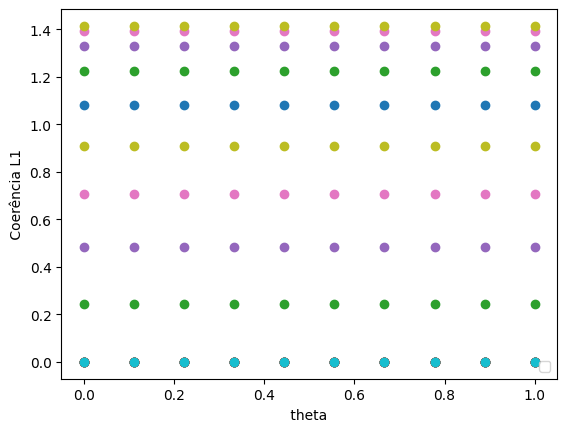

In [4]:
from numpy import linspace
import matplotlib.pyplot as plt
import numpy as np 
import math


def coh_l1(rho):  # normalized to [0,1]
    d = rho.shape[0]
    coh = 0.0
    for j in range(0, d-1):
        for k in range(j+1, d):
            coh += math.sqrt((rho[j][k].real)**2.0 + (rho[j][k].imag)**2.0)
    return 2.0*coh/(d-1)

def pTraceL_num(dl, dr, rhoLR):
    # Returns the left partial trace over the 'left' subsystem of rhoLR
    rhoR = np.zeros((dr, dr), dtype=complex)
    for j in range(0, dr):
        for k in range(j, dr):
            for l in range(0, dl):
                rhoR[j,k] += rhoLR[l*dr+j,l*dr+k]
            if j != k:
                rhoR[k,j] = np.conj(rhoR[j,k])
    return rhoR

def pTraceR_num(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoL = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoL[j,k] += rhoLR[j*dr+l,k*dr+l]
        if j != k:
            rhoL[k,j] = np.conj(rhoL[j,k])
    return rhoL

def plot_cohs(list_p, rho_list):
    for rho in rho_list:
        coerencias_R = []
        coerencias_L = []
        for p in list_p:
            #rho = rhoAB_bpf_sympy(pi/2, 0, 0.5)
    
    
            rhoA_R = pTraceR_num(2,2,rho)
            rhoA_L = pTraceL_num(2,2,rho)
            cA_R = coh_l1(rhoA_R)
            cA_L = coh_l1(rhoA_L)
            coerencias_R.append(cA_R)
            coerencias_L.append(cA_L)
        plt.scatter(list_p,coerencias_R)
        plt.scatter(list_p,coerencias_L)

#list_gamma = linspace(0,1,10)
list_p = linspace(0,1,10)

rho_list = []
#for p in list_p:
#    rho = rhoAB_bpf_sympy(pi/40, 20, p)
list_theta = np.linspace(0,np.pi,10)
for theta in list_theta:
    rho = rhoAB_bpf_sympy(theta, 0, 0.5)
    rho_list.append(rho)
plot_cohs(list_p,rho_list)
plt.xlabel(' theta ')
plt.ylabel(' Coerência L1 ')
plt.legend(loc=4)
plt.show()
###for g in list_gamma:
##rho_list = []
##for p in list_p:
##    rho = rhoAB_bpf_sympy(pi/2, 0, p)
##    rho_list.append(rho)
##    
##    rhoA_R = pTraceR_num(2,2,rho)
##    rhoA_L = pTraceL_num(2,2,rho)
##    cA_R = coh_l1(rhoA_R)
##    cA_L = coh_l1(rhoA_L)
##    coerencias_R.append(cA_R)
##    coerencias_L.append(cA_L)
##plt.plot(list_p,coerencias_R,label='Rho_R')
##plt.plot(list_p,coerencias_L,label='Rho_L')
##plt.xlabel(' p ')
##plt.ylabel(' Coerência L1 ')
##plt.legend(loc=4)
##plt.show()

In [5]:
from numpy import linspace
list_p = linspace(0,1,15)


#for g in list_gamma:
rho_list = []
list_theta = [ pi/2, pi/3, pi/4, pi/5, pi/6, pi/7]
coerencias_R = []
coerencias_L = []
theta = pi/2
for p in list_p:
    #rho = rhoAB_bpf_sympy(theta, 0, p)
    rho = calculated_rho_A(theta, 0, p)
    theta = theta-0.25
    #rho_list.append(rho)
    
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)
plt.plot(list_p,coerencias_R,label=f'theta inicial = {theta}')
#plt.plot(list_p,coerencias_L,label='Rho_L')
plt.xlabel(' p ')
plt.ylabel(' Coerência L1 ')
plt.legend(loc=4)
plt.show()

IndexError: Index out of range: a[1]

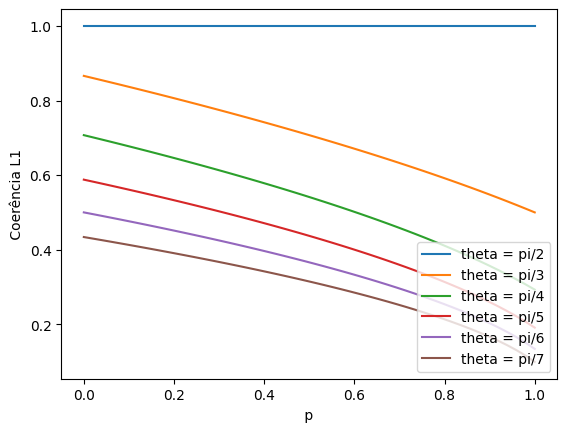

In [11]:

#list_gamma = linspace(0,1,10)
list_p = linspace(0,1,50)


#for g in list_gamma:
rho_list = []
list_theta = [ pi/2, pi/3, pi/4, pi/5, pi/6, pi/7]
for theta in list_theta:
    coerencias_R = []
    coerencias_L = []
    for p in list_p:
        rho = rhoAB_bpf_sympy(theta, 0, p)
        rho_list.append(rho)
        
        rhoA_R = pTraceR_num(2,2,rho)
        rhoA_L = pTraceL_num(2,2,rho)
        cA_R = coh_l1(rhoA_R)
        cA_L = coh_l1(rhoA_L)
        coerencias_R.append(cA_R)
        coerencias_L.append(cA_L)
    plt.plot(list_p,coerencias_R,label=f'theta = {theta}')
    #plt.plot(list_p,coerencias_L,label='Rho_L')
plt.xlabel(' p ')
plt.ylabel(' Coerência L1 ')
plt.legend(loc=4)
plt.show()

In [ ]:
list_p = linspace(0,1,50)

coerencias_R = []
coerencias_L = []
#for g in list_gamma:
def plot_cohs(list_p, rho_list):
    for rho in rho_list:
        for p in list_p:
            rho = rhoAB_bpf_sympy(pi/2, 0, 0.5)
    
    
            rhoA_R = pTraceR_num(2,2,rho)
            rhoA_L = pTraceL_num(2,2,rho)
            cA_R = coh_l1(rhoA_R)
            cA_L = coh_l1(rhoA_L)
            coerencias_R.append(cA_R)
            coerencias_L.append(cA_L)
        plt.plot(list_p,coerencias_R,label=f'Rho_R({p})')
        plt.plot(list_p,coerencias_L,label=f'Rho_L({p})')
plt.xlabel(' p ')
plt.ylabel(' Coerência L1 ')
plt.legend(loc=4)
plt.show()

In [10]:
def trace(A):
    d = A.shape[0]; tr = 0.0
    for j in range(0,d):
       tr += A[j,j]
    return tr
trace(result).subs(theta,pi).subs(gamma,0.5).subs(p,1)

1.00000000000000

In [ ]:
from sympy.physics.quantum import TensorProduct
from sympy import conjugate

rho_AB = TensorProduct(conjugate(Psi_AB),Psi_AB)
rho_AB

Matrix([
[                                       cos(conjugate(theta)/2)*conjugate(sqrt(p))],
[      exp(-1.0*I*conjugate(phi))*sin(conjugate(theta)/2)*conjugate(sqrt(gamma*p))],
[                     cos(conjugate(theta)/2)*conjugate(sqrt((1 - gamma)*(1 - p)))],
[                                                                                0],
[exp(-1.0*I*conjugate(phi))*sin(conjugate(theta)/2)*conjugate(sqrt(p*(1 - gamma)))],
[                                                                                0],
[        exp(-1.0*I*conjugate(phi))*sin(conjugate(theta)/2)*conjugate(sqrt(1 - p))],
[                  cos(conjugate(theta)/2)*conjugate(gamma)*conjugate(sqrt(1 - p))]])xMatrix([
[                           sqrt(p)*cos(theta/2)],
[      sqrt(gamma*p)*exp(1.0*I*phi)*sin(theta/2)],
[         sqrt((1 - gamma)*(1 - p))*cos(theta/2)],
[                                              0],
[sqrt(p*(1 - gamma))*exp(1.0*I*phi)*sin(theta/2)],
[                                             

In [ ]:
from sympy.vector import CoordSys3D
N = CoordSys3D('N')
v1 = 2*N.i+3*N.j-N.k
v2 = N.i-4*N.j+N.k
v1.dot(v2)
v3 = v1.cross(v2)
v3

(-1)*N.i + (-3)*N.j + (-11)*N.k

In [ ]:
target_op = state_generalized_amplitude_damping(np.pi/2, 0, p,1)
alpha = eval(input("How many rows? "))
beta = eval(input("How many columns? "))

def make_matrix(alpha,beta):
    matrix_thing = SHIT.random.randint(0,50,(alpha,beta))
    return(matrix_thing)

matrix_sympy = Matrix(make_matrix(alpha, beta))